# VIZBI Tutorial Session
### Part 2: Cytoscape, IPython, Docker, and reproducible network data visualization workflows

Tuesday, 3/24/2015


### Lesson 3: Reproducible Visualization Workflow

by [Keiichiro Ono](http://keiono.github.io/)

----

![](http://cl.ly/aKS1/tca1.png)


## Background 
You can visualize network data set using easy-to-use Cytoscape GUI and you can save the final result as a ___session file___.  But if you need to create similar visualizations, you need to repeat the manual (point-and-click) operations again.  This will be more and more time consuming process as your data sets grows.  Good news is, you can avoid it by writing your visualization workflow as Notebooks!

In [1]:
import requests
import json
from IPython.display import Image
import pandas as pd

# Basic Setup
PORT_NUMBER = 1234
IP = '137.110.137.158' # Dont' forget to update this!!!!!!!!!!!!!!!
BASE = 'http://' + IP + ':' + str(PORT_NUMBER) + '/v1/'
HEADERS = {'Content-Type': 'application/json'}

# Utulity to POST object
def create(param, dict_data):
    return requests.post(BASE + param, data=json.dumps(dict_data), headers=HEADERS)

def update(param, dict_data):
    return requests.put(BASE + param, data=json.dumps(dict_data), headers=HEADERS)
    
# Start from a clean slate!
requests.delete(BASE + 'session')

<Response [200]>

## Visual Style

![](http://cl.ly/aJam/visualstyles.png)

To visuaize your data with Cytoscape, you need to understand its data-to-view mapping mechanism called ___Visual Style___.

### What is a Visual Style?
__Visual Style is a collection of instructions how to map your data to visual properties (or visual variables)__.  To use it to make effective visualizations, you need to understand the following concepts.

In [46]:
# Get a list of all available Visual Styles
vs_url = BASE + 'styles'
res = requests.get(vs_url)
style_df = pd.DataFrame(res.json(), columns=['Style Name'])
style_df

,Style Name
0,default


#### Visual Properties
Visual Properties, sometimes called [visual variables](http://www.infovis-wiki.net/index.php?title=Visual_Variables) in other applications, are properties of viewable objects, such as color, shape, opacity, size, etc.

You can get the complete list of Visual Properties with the following code:

In [47]:
vps_url = BASE + 'styles/visualproperties'
print(vps_url)

# Let's make it a bit more human readable
res = requests.get(vps_url)
vp_df = pd.DataFrame(res.json(), columns=['visualProperty', 'name', 'targetDataType', 'default'])
vp_df.tail()

http://192.168.100.172:1234/v1/styles/visualproperties


,visualProperty,name,targetDataType,default
98,NODE_VISIBLE,Node Visible,CyNode,true
99,NODE_WIDTH,Node Width,CyNode,60.0
100,NODE_X_LOCATION,Node X Location,CyNode,0.0
101,NODE_Y_LOCATION,Node Y Location,CyNode,0.0
102,NODE_Z_LOCATION,Node Z Location,CyNode,0.0


##### Discrete Range Values
Some of the Visual Properties have set of disrete values.  You can access those by _values_ API:

In [48]:
res = requests.get(vps_url + '/NODE_SHAPE/values')
node_shapes = pd.DataFrame(res.json()['values'], columns=['Node Shapes'])
node_shapes

,Node Shapes
0,VEE
1,DIAMOND
2,RECTANGLE
3,PARALLELOGRAM
4,TRIANGLE
5,HEXAGON
6,ROUND_RECTANGLE
7,ELLIPSE
8,OCTAGON


#### Defaults
By default, there is no mapping from your data to Visual Properties.  __If there is no mapping for a Visual Property, default value will be used.__

In [49]:
directed_style_url = BASE + 'styles/default/defaults'
print(directed_style_url)

res = requests.get(directed_style_url)
defaults_df = pd.DataFrame(res.json()['defaults'], columns=['visualProperty', 'value'])
defaults_df.head()

http://192.168.100.172:1234/v1/styles/default/defaults


,visualProperty,value
0,EDGE_BEND,
1,EDGE_CURVED,True
2,EDGE_LABEL,
3,EDGE_LABEL_COLOR,#000000
4,EDGE_LABEL_FONT_FACE,"Dialog,plain,10"


Let's try with actual network data.

In [50]:
# Load a network file
f = open('data/yeast.json', 'r')
cyjs_network = json.load(f)
cyjs_network['data']['name'] = 'Yeast 1' 

res = create('networks', cyjs_network)
suid = res.json()['networkSUID']

# Apply Visual Style "default"
requests.get(BASE + 'apply/styles/default')
requests.get(BASE + 'apply/layouts/degree-circle/' + str(suid))

paints = defaults_df[defaults_df['visualProperty'].str.contains('COLOR')]

paints.tail(10)

,visualProperty,value
3,EDGE_LABEL_COLOR,#000000
77,NODE_FILL_COLOR,#0099CC
80,NODE_LABEL_COLOR,#FFFFFF


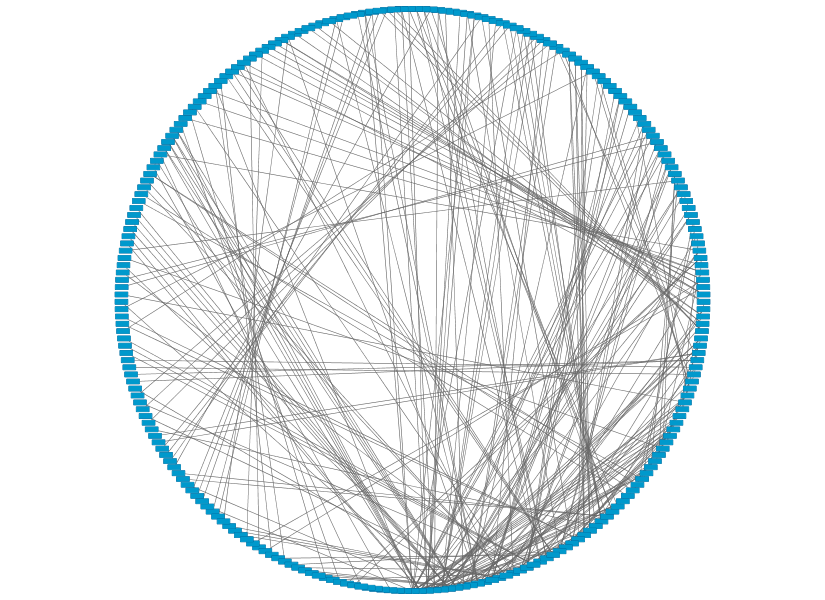

In [51]:
Image(BASE+'networks/' + str(suid) + '/views/first.png')

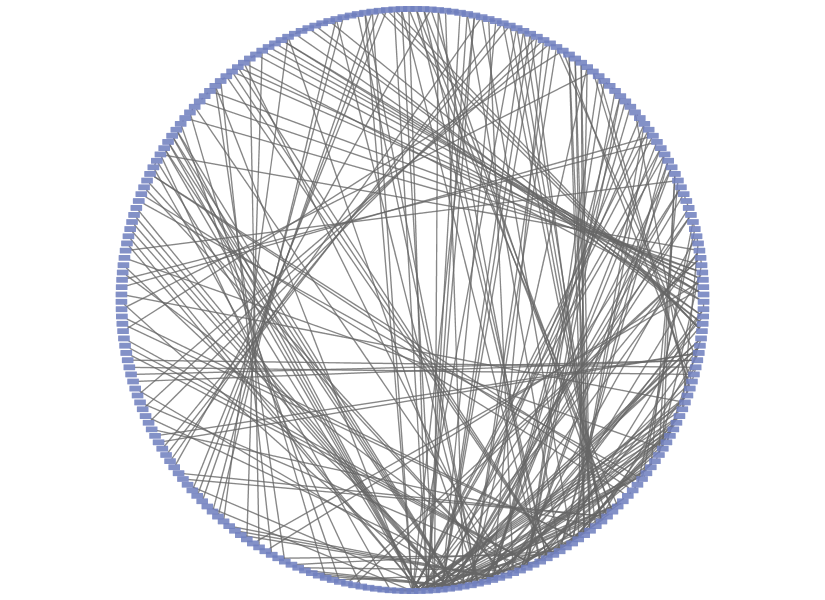

In [52]:
# Let's change some default values.
new_values = [
    {
        'visualProperty':'NODE_FILL_COLOR',
        'value': '#7080BF'
    },
    {
        'visualProperty':'NODE_BORDER_WIDTH',
        'value': 0
    },
    {
        'visualProperty':'NODE_LABEL_FONT_SIZE',
        'value': 90
    },
    {
        'visualProperty':'NODE_WIDTH',
        'value': 60
    },
    {
        'visualProperty': 'EDGE_WIDTH',
        'value': 7
    },
    {
        'visualProperty': 'NODE_TRANSPARENCY',
        'value': 220
    },
    {
        'visualProperty': 'EDGE_TRANSPARENCY',
        'value': 200
    }
]

update('styles/default/defaults', new_values)
Image(BASE+'networks/' + str(suid) + '/views/first.png')

### Excercise: Update default Values
* Node Color
* Edge Width
* Node Shape


In [53]:
# Write your code here...

#### Mappings
Mappings , or Visual Mapping Functions, are the actual mechanism to map data points to Visual Property values.  There are three types of mappings: discrete, continuous, and passthrough.

##### Passthrough
___Passthrough Mapping___ is the simplest mapping mechanism in Cytoscape.  It simply map values to Visual Property.  For example, if you create a node name to node label mapping, it simply passes the node name text to the Mapping Function and displays as node label. 

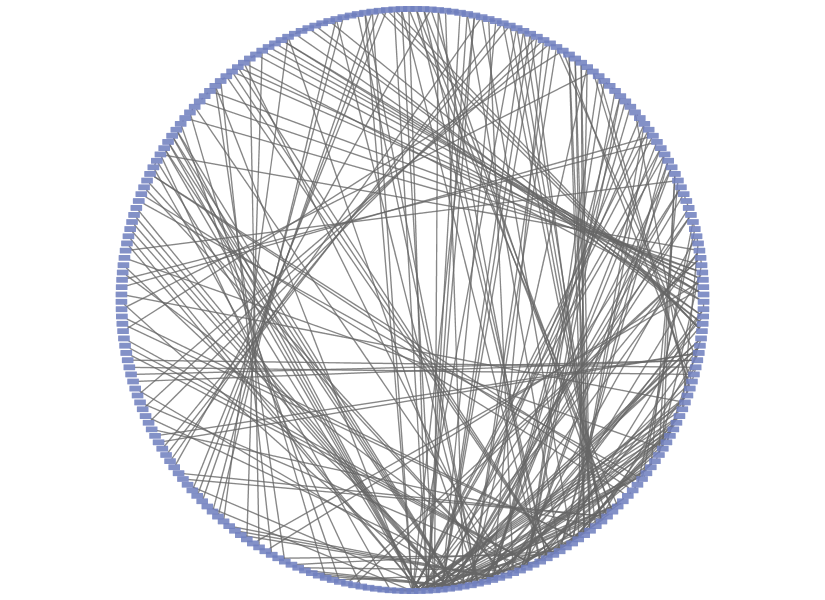

In [54]:
# Create a Passthrough mapping
new_passthrough_mapping = {
    'mappingType': 'passthrough',
    'mappingColumn': 'degree.layout',
    'mappingColumnType': 'Integer',
    'visualProperty': 'NODE_LABEL',
}

# Create a new style by POSTing the object
create('styles/default/mappings', [new_passthrough_mapping])
Image(BASE+'networks/' + str(suid) + '/views/first.png')

##### Discrete
Discrete mapping is the one maps discrete data points to any Visual Properties.  Here is the list of typical discrete mappings:

* Node type (gene, protein complex, small compounds, etc.) to node shape
* Node type to size
* Interaction type (inhibition / activation) to arrow shape
* Interaction detection method (Y2H, co-expression, text mining, etc.) to edge line style

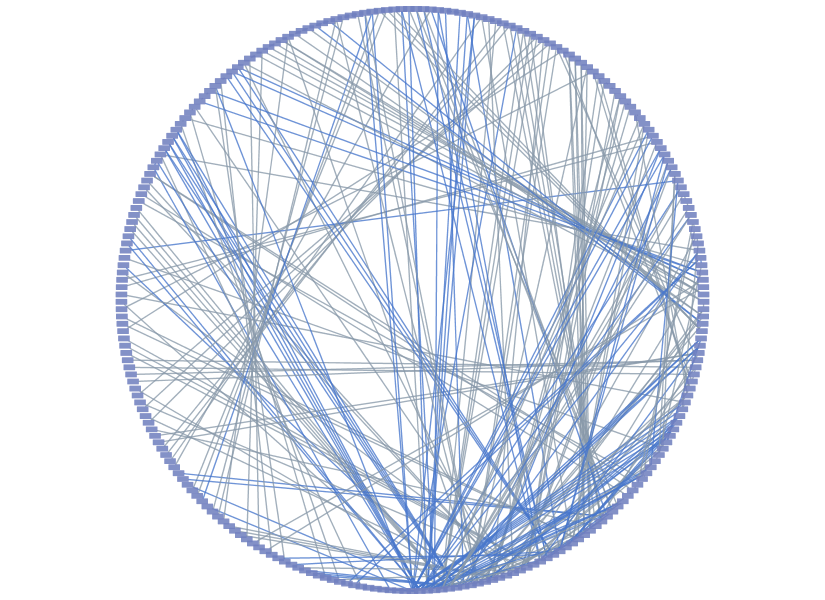

In [55]:
# Create discrete mapping
new_disc_mapping = {
    'mappingType': 'discrete',
    'mappingColumn': 'interaction',
    'mappingColumnType': 'String',
    'visualProperty': 'EDGE_STROKE_UNSELECTED_PAINT',
    'map':[
        {
            'key': 'pp',
            'value': '#8899aa'
        },
        {
            'key': 'pd',
            'value': '#4876cc'
        }
    ]
}

line_style_mapping = {
    'mappingType': 'discrete',
    'mappingColumn': 'interaction',
    'mappingColumnType': 'String',
    'visualProperty': 'EDGE_LINE_STYLE',
    'map':[
        {
            'key': 'pp',
            'value': 'SOLID'
        },
        {
            'key': 'pd',
            'value': 'LONG_DASH'
        }
    ]
}

create('styles/default/mappings', [new_disc_mapping])
Image(BASE+'networks/' + str(suid) + '/views/first.png')

##### Continuous

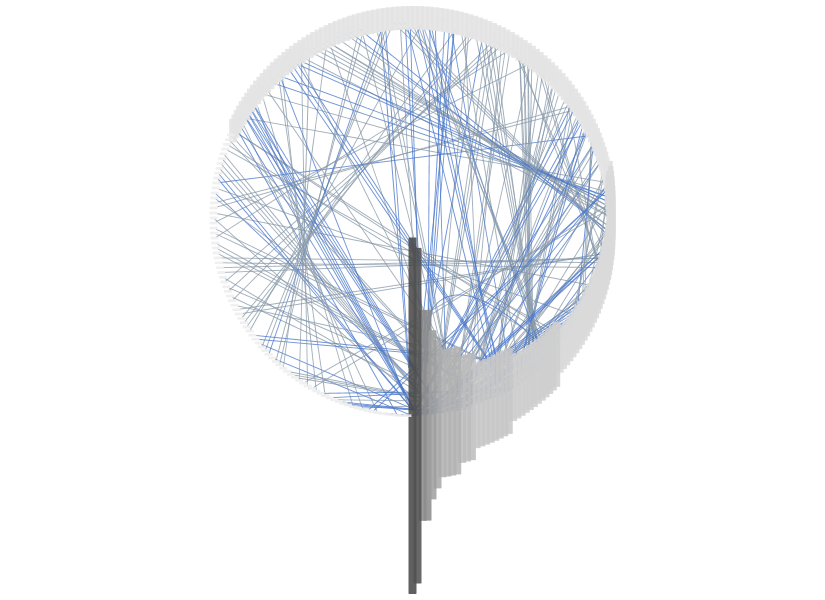

In [56]:
new_cont_mapping = {
    'mappingType': 'continuous',
    'mappingColumn': 'degree.layout',
    'mappingColumnType': 'Integer',
    'visualProperty': 'NODE_HEIGHT',
    'points':[
        {
            'value': 1,
            'lesser': '20',
            'equal': '20',
            'greater': '20'
        },
        {
            'value': 20,
            'lesser': '3000',
            'equal': '3000',
            'greater': '3000'
        }
    ]
}

new_color_mapping = {
    'mappingType': 'continuous',
    'mappingColumn': 'degree.layout',
    'mappingColumnType': 'Integer',
    'visualProperty': 'NODE_FILL_COLOR',
    'points':[
        {
            'value': 1,
            'lesser': '#EEEEEE',
            'equal': '#EEEEEE',
            'greater': '#EEEEEE'
        },
        {
            'value': 20,
            'lesser': '#333333',
            'equal': '#333333',
            'greater': '#333333'
        }
    ]
}
create('styles/default/mappings', [new_cont_mapping, new_color_mapping])
Image(BASE+'networks/' + str(suid) + '/views/first.png')

Now you can see the new mapping in the Cytoscape's Control Panel:

![](http://cl.ly/aKNs/cont_mapping1.png)


### Apply Automatic Layout

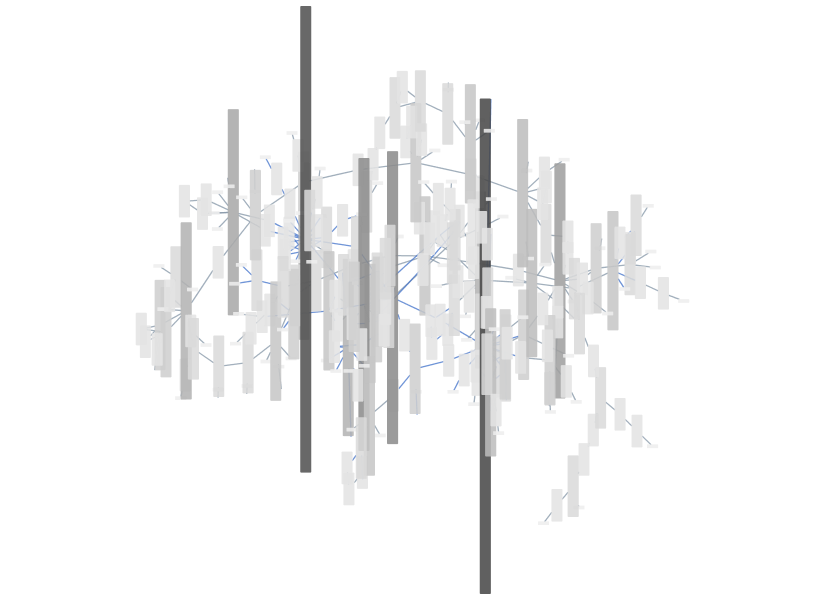

In [57]:
# Apply force-directd layout
requests.get(BASE + 'apply/layouts/force-directed/' + str(suid))
Image(BASE+'networks/' + str(suid) + '/views/first.png')

## Discussion
OK, now you can create any mappings from Python.  But editing code like this manyally is a pain...  

### _Don't repeat yourself!_
The true power of __workflow-as-code__ is its reproducibility.  You can easily apply your existing code to other data sets.  The first step to reusability is writing common tasks as functions.

In [58]:
def get_basic_mapping(map_type, column, column_type, vp):
    new_mapping = {
         'mappingType': map_type,
        'mappingColumn': column,
        'mappingColumnType': column_type,
        'visualProperty': vp,
    }
    return new_mapping
    
def get_discrete_mapping(column, column_type, vp):
    mapping = get_basic_mapping('discrete', column, column_type, vp)
    mapping['map'] = []
    return mapping

def get_continuous_mapping(column, column_type, vp):
    mapping = get_basic_mapping('continuous', column, column_type, vp)
    mapping['points'] = []
    return mapping

def get_passthrough_mapping(column, column_type, vp):
    return get_basic_mapping('passthrough', column, column_type, vp)

And now you can do all kinds of crazy thing if you want...

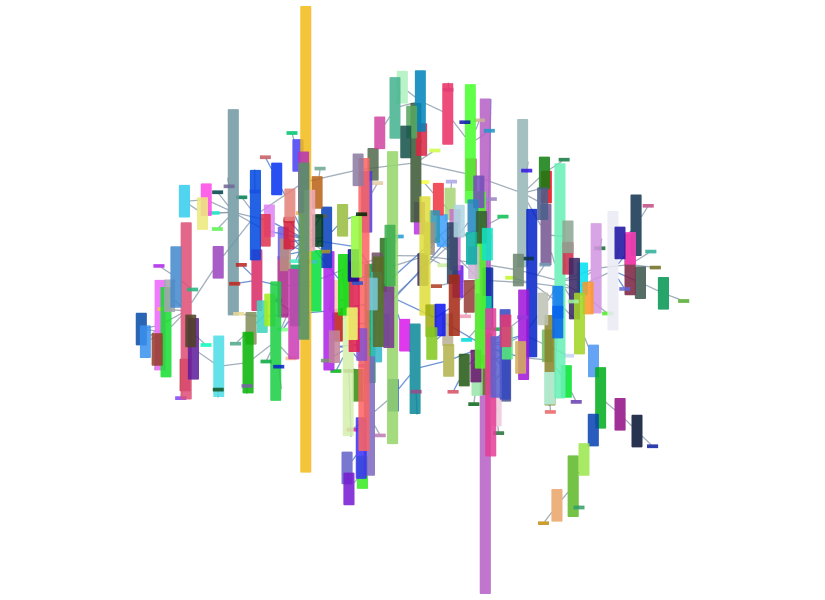

In [59]:
# Find network ID
res = requests.get(BASE + 'networks/' + str(suid) + '/nodes')
node_suids = res.json()

import random

random_colors = []
for node in node_suids:
    entry = {
        'key': str(node),
        'value': '#' + format(random.randint(1,255), 'X') + format(random.randint(1,255), 'X') + format(random.randint(1,255), 'X')
    }
    random_colors.append(entry)
    
random_color_mapping = get_discrete_mapping('SUID', 'Long', 'NODE_FILL_COLOR')
random_color_mapping['map'] = random_colors

create('styles/default/mappings', [random_color_mapping])
Image(BASE+'networks/' + str(suid) + '/views/first.png')

And it is easy to reset it, by simply deleting the mapping.

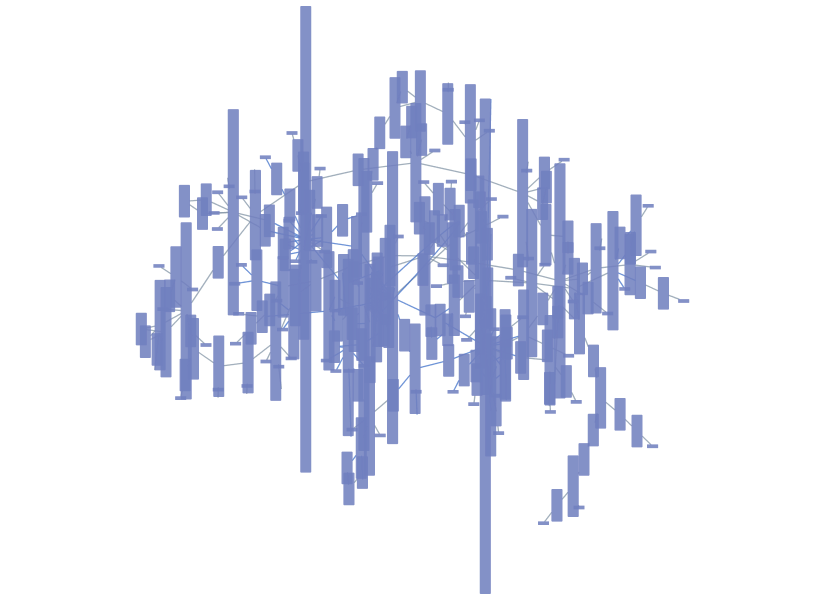

In [60]:
res = requests.delete(BASE + 'styles/default/mappings/NODE_FILL_COLOR')
Image(BASE+'networks/' + str(suid) + '/views/first.png')

#### Is it worth wrting a new Python package?


### Directly Set Visual Properties
In general, Cytoscape visualizations are controlled by _Visual Styles_.  However, in some cases, you may want to edit the view directly.  Typical example is layout.  cyREST provides low level API to access View objects.  In this section, you will learn how to set view values through writing your own layout algorithm.

### Write your own layout algorithm
You can move node (x,y) positions by setting new values for two Visual Properties:
* __NODE_X_LOCATION__
* __NODE_Y_LOCATION__

The following is a simple example to arrange all nodes in one line.

http://192.168.100.172:1234/v1/networks/166725/views/167283.png?h=700


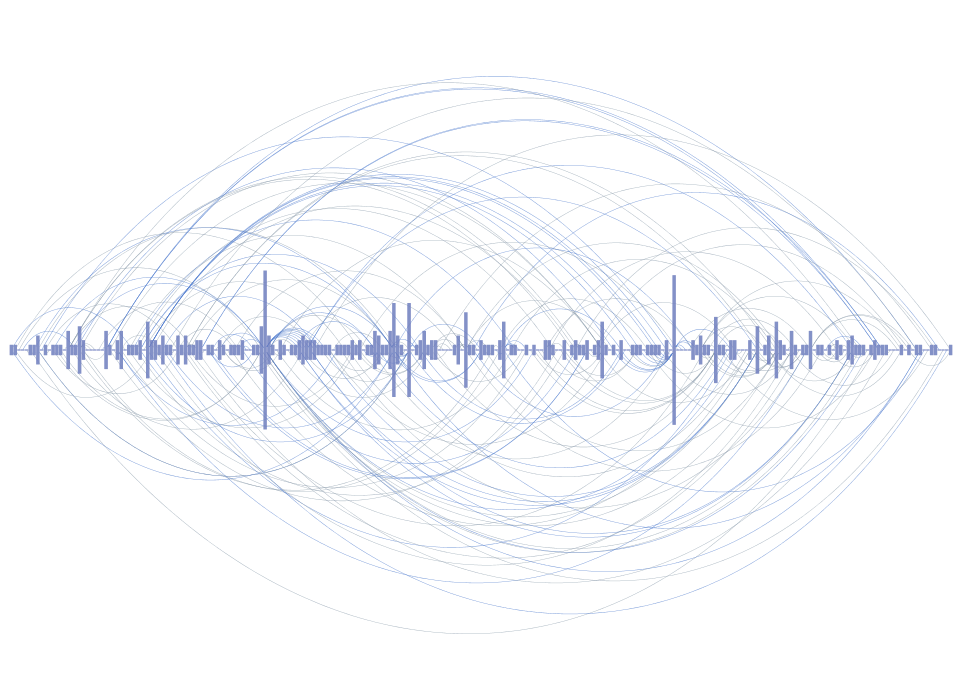

In [61]:
# Find the Network View ID
res = requests.get(BASE + 'networks/' + str(suid) + '/views')
view_id = res.json()[0]
DISPLACEMENT = 64

def linear_layout(suid, node_list):
    # Node X Position = size
    position_list= []
    start_pos = 0
    for node in node_list:
        position = {
            'SUID': node,
            'view':[
                {
                    'visualProperty': 'NODE_X_LOCATION',
                    'value': start_pos
                },
                {
                    'visualProperty': 'NODE_Y_LOCATION',
                    'value': 0
                }
            ]
        }
        position_list.append(position)
        start_pos = start_pos + DISPLACEMENT
    return position_list
    

# Add edge bend information
bend = [
    {
        'visualProperty':'EDGE_BEND',
        'value': '0.5,-0.9,0.9'
    }
]
update('styles/default/defaults', bend)

posx = linear_layout(view_id, node_suids)
node_views_url = 'networks/' + str(suid) + '/views/' + str(view_id) + '/nodes'
res = update(node_views_url, posx)
requests.get(BASE + 'apply/fit/' + str(suid))

image_url = BASE+'networks/' + str(suid) + '/views/' + str(view_id) + '.png?h=700'
print(image_url)
res = requests.get(image_url)
Image(res.content)

In [62]:
res = requests.get(BASE + 'networks/' + str(suid) + '/tables/defaultnode')
rows = res.json()['rows']
node_table_df = pd.DataFrame(rows)
node_table_df.head(10)

,SUID,degree_layout,id,name,selected,shared_name
0,166735,2,465,YIL162W,False,YIL162W
1,166736,2,469,YOR355W,False,YOR355W
2,166737,1,467,YFL038C,False,YFL038C
3,166738,1,477,YML123C,False,YML123C
4,166739,1,480,YHR071W,False,YHR071W
5,166740,2,479,YPL031C,False,YPL031C
6,166741,2,485,YDR009W,False,YDR009W
7,166742,4,483,YML051W,False,YML051W
8,166743,1,490,YML024W,False,YML024W
9,166744,2,488,YIL113W,False,YIL113W


In [63]:
sorted_nodes = node_table_df.sort_index(by=['degree_layout'])
sorted_nodes.tail(10)

,SUID,degree_layout,id,name,selected,shared_name
36,166771,7,388,YPL075W,False,YPL075W
156,166891,7,168,YDR412W,False,YDR412W
130,166865,7,196,YEL009C,False,YEL009C
202,166937,7,110,YJR022W,False,YJR022W
186,166921,8,660,YDR395W,False,YDR395W
120,166855,9,216,YLR362W,False,YLR362W
105,166840,11,231,YPL248C,False,YPL248C
101,166836,11,225,YGL035C,False,YGL035C
175,166910,17,128,YNL216W,False,YNL216W
67,166802,18,286,YMR043W,False,YMR043W


http://192.168.100.172:1234/v1/networks/166725/views/167283.png?h=650


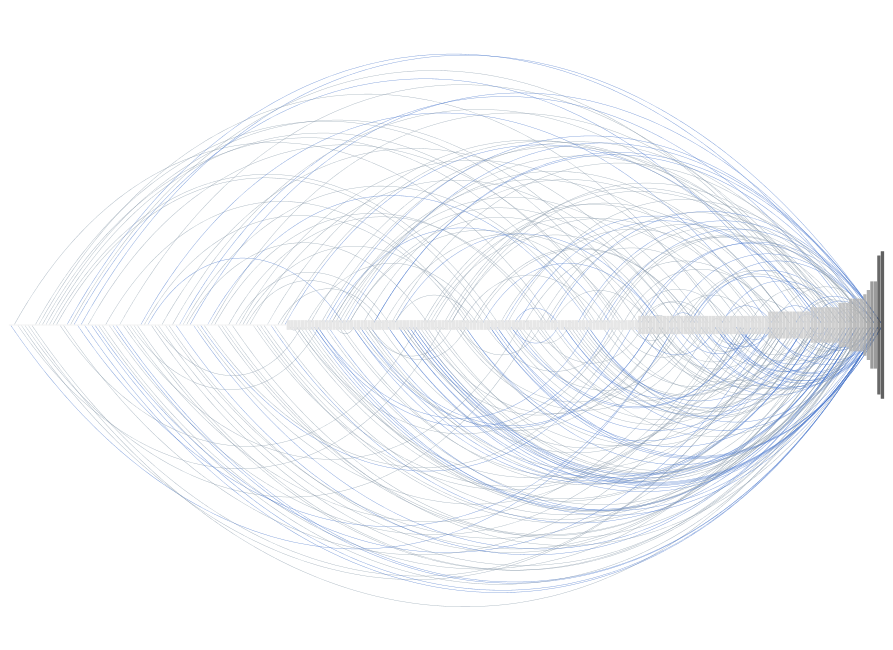

In [64]:
sorted_node_suids = sorted_nodes['SUID']
pos2 = sorted_node_suids.apply(lambda x: str(x))
posx = linear_layout(view_id, pos2.tolist())

res = update(node_views_url, posx)
requests.get(BASE + 'apply/fit/' + str(suid))

create('styles/default/mappings', [new_color_mapping])

image_url = BASE+'networks/' + str(suid) + '/views/' + str(view_id) + '.png?h=650'
print(image_url)
res = requests.get(image_url)

Image(res.content)

## Save the final result as a _Session File_
And now you can save the entire process as Notebooks, and the result as ___Session File___.

In [65]:
session_file_name = {
    'file': '/Users/kono/Desktop/yeast_session.cys'
}
res = requests.post(BASE + 'session',  params=session_file_name, data=None, headers=HEADERS)
print(json.dumps(res.json(), indent=4))

{
    "file": "/Users/kono/Desktop/yeast_session.cys"
}


## Summary
All of the visualizations you created here are reproducible, only with one click (___Run All___ under _Cell_ menu).  In addition, you can reuse the code segments here to make more effective, realistic data visualizations.